# Решение спитцеровского уравнения теплопроводности плазмы

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.pyplot import axes
from celluloid import Camera
from numba import njit
import utils

## Неявная разностная схема с нелинейностью на верхнем слое

Для численного решения задачи будем использовать неявную разностную схему с нелинейностью на нижнем слое

$$
\frac{y^{n+1}_{m} - y^{n}_{m}}{\tau} = \frac{1}{h}\left[k^{n + 1}_{m + 1/2}\frac{y^{n+1}_{m+1} - y^{n+1}_{m}}{h} - k^{n+1}_{m - 1/2}\frac{y^{n+1}_{m} - y^{n+1}_{m - 1}}{h}\right]
$$

In [22]:
@njit
def k_12(y_m, y_m_1, alpha, kappa=1):
    return kappa * (y_m ** alpha + y_m_1 ** alpha) / 2

In [23]:
from numpy.linalg import inv

@njit
def thomas_block_solver(A, B, C, D):
    M = len(D)
    u_sol = np.zeros_like(D)
    P = np.zeros_like(B)
    Q = np.zeros_like(D)
    # Forward first coefs
    P[0] = inv(B[0]) @ C[0]
    Q[0] = - inv(B[0]) @ D[0]
    # Forward coefs
    for m in range(1, M - 1):
        inv_denom = inv(B[m] - A[m - 1] @ P[m - 1])
        P[m] = inv_denom @ C[m]
        Q[m] = inv_denom @ (A[m - 1] @ Q[m - 1] - D[m])
    #Forward last
    m = M - 1
    Q[m] = inv(B[m] - A[m - 1] @ P[m - 1]) @ (A[m - 1] @ Q[m - 1] - D[m])

    # backward
    u_sol[-1] = Q[-1]
    for m in range(M - 1, -1, -1):
        u_sol[m - 1] = P[m - 1] @ u_sol[m] + Q[m - 1]

    return u_sol

In [24]:
@njit
def qei(y):
    Te, Ti = y
    if Te == 0:
        return 0, 0, 0
    try:
        q = (Te - Ti) / Te ** 2
        dq_dTe = (2 * Te * Ti - Te ** 2) / Te ** 4
        dq_dTi = - 1 / Te ** 2
    except Exception:
        q, dq_dTe, dq_dTi = 0, 0, 0
    return q, dq_dTe, dq_dTi

In [25]:
from numpy.linalg import norm

def make_block(u, m, tau, h, u_n, alpha=(2.5, 1.5), kappa=(0.2, 0.3)):
    alpha = np.array(alpha)
    kappa = np.array(kappa)
    sigma = tau / h ** 2
    A, B, C, D = np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((2, 2)), np.zeros((2, 2))
    dkappa = lambda x: kappa * 0.5 * alpha * x ** (alpha - 1)
    q, dq_dTe, dq_dTi = qei(u[m])
    dphi_dy = np.array([- dq_dTe, dq_dTi])
    phi = np.array([- q, q])
    if m == 0:
        C = np.diagflat(k_12(u[m], u[m + 1], alpha, kappa) + dkappa(u[m + 1]) * (u[m + 1] - u[m]))
        B = np.diagflat(1 / sigma + k_12(u[m], u[m + 1], alpha, kappa) - dkappa(u[m]) * (u[m + 1] - u[m]))
        B -= np.diagflat(h ** 2 * dphi_dy)
        B[0, 1], B[1, 0] = dphi_dy[1], dphi_dy[0]
        D = (u[m] - u_n[m]) / sigma - k_12(u[m + 1], u[m], alpha, kappa) * (u[m + 1] - u[m])
        D -= h ** 2 * phi
        return C, B, D
    A = np.diagflat(k_12(u[m - 1], u[m], alpha, kappa) - dkappa(u[m - 1]) * (u[m] - u[m - 1]))
    C = np.diagflat(k_12(u[m], u[m + 1], alpha, kappa) + dkappa(u[m + 1]) * (u[m + 1] - u[m]))
    B = np.diagflat(1 / sigma + k_12(u[m], u[m + 1], alpha, kappa) + k_12(u[m - 1], u[m], alpha, kappa) - dkappa(u[m]) * (u[m + 1] - u[m]) + dkappa(u[m]) * (u[m] - u[m - 1]))
    D = (u[m] - u_n[m]) / sigma - k_12(u[m + 1], u[m], alpha, kappa) * (u[m + 1] - u[m]) + k_12(u[m], u[m - 1], alpha, kappa) * (u[m] - u[m - 1])
    if norm(h ** 2 * dphi_dy) / norm(np.diag(B)) < 1e14:
        B -= np.diagflat(h ** 2 * dphi_dy)
        B[0, 1], B[1, 0] = h ** 2 * dphi_dy[1], h ** 2 * dphi_dy[0]
        D -= h ** 2 * phi
    return A, B, C, D

In [26]:
def make_block_diagonals(u1_s, u2_s, tau, h, u1_n, u2_n, alpha=(2.5, 1.5), kappa=(0.2, 0.3)):
    M = len(u1_s)
    A = np.zeros((M - 1, 2, 2))
    B = np.zeros((M, 2, 2))
    C = np.zeros((M - 1, 2, 2))
    D = np.zeros((M, 2))
    u_s = np.vstack([u1_s, u2_s]).T
    u_n = np.vstack([u1_n, u2_n]).T
    # first row
    C[0], B[0], D[0] = make_block(u_s, 0, tau, h, u_n, alpha=alpha, kappa=kappa)
    # rows m = 1, ..., M - 2
    for m in range(1, M - 1):
        A[m - 1], B[m], C[m], D[m] = make_block(u_s, m, tau, h, u_n, alpha=alpha, kappa=kappa)
    # last row
    B[M - 1] = np.eye(2)
    return A, B, C, D

In [27]:
def newton_solver(u1, u2, tau, h, alpha=(2.5, 1.5), kappa=(0.2, 0.3), iter=10):
    u1_s, u2_s = u1, u2
    for i in range(iter):
        A, B, C, D = make_block_diagonals(u1_s, u2_s, tau, h, u1, u2, alpha=alpha, kappa=kappa)
        du = thomas_block_solver(A, B, C, D)
        u1_s = u1_s + du[:, 0]
        u2_s = u2_s + du[:, 1]
    return u1_s, u2_s

### Применение

In [35]:
# Начальные значения
a = 0
b = 4
t_0 = 0
T = 4
To = 2
const = 3
alpha = 2.5
kappa = 0.2

print(f'v = {np.sqrt(const ** (1 / alpha) * kappa / alpha)}')

v = 0.3523459179744088


In [36]:
# Число узлов
N = 6000
M = 200

# Размер шага сетки
h = (b - a) / (M - 1)
tau = (T - t_0) / (N - 1)
print(f'{h=: .8f}, {tau=: .8f}')
print(f'sigma = {tau / h ** 2 * 0.5: .4f}')

h= 0.02010050, tau= 0.00066678
sigma =  0.8252


In [37]:
t = np.linspace(t_0, T, N)
x = np.linspace(a, b, M)

In [38]:
def u_init(x, To):
    u = np.zeros(x.size)
    for i in range(len(x)):
        if x[i] <= 1:
            u[i] = To
    return u

In [39]:
u1 = np.zeros((N, M), dtype=np.double)
u1[0, :] = u_init(x, To)
u2 = np.zeros((N, M), dtype=np.double)
u2[0, :] = u_init(x, To)

In [40]:
np.seterr(divide='raise', invalid='raise')

{'divide': 'raise', 'over': 'warn', 'under': 'ignore', 'invalid': 'raise'}

In [41]:
for n in tqdm(range(N - 1)):
    u1_sol, u2_sol = newton_solver(u1[n, :], u2[n, :], tau, h, alpha=(2.5, 1.5), kappa=(0.2, 0.3), iter=2)
    u1[n + 1, :], u2[n + 1, :] = u1_sol, u2_sol

  0%|          | 0/5999 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [77]:
from scipy.optimize import root
root()

#### Визуализация

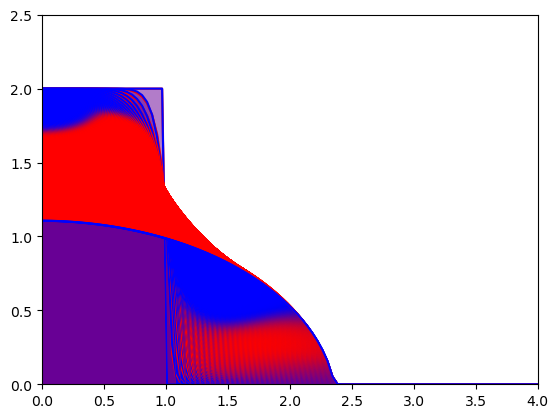

In [75]:
fig = plt.figure()
camera = Camera(fig)
ax = axes(xlim=(a, b), ylim=(0, 2.5))

for i in range(0, N, 10):
    ax.plot(x, u1[i, :], color="red")
    ax.fill_between(x, u1[i, :], color='red', alpha=0.3)
    ax.plot(x, u2[i, :], color="blue")
    ax.fill_between(x, u2[i, :], color='blue', alpha=0.3)
    #zeld_sol = zeldovich_solution(x, t[i], alpha, kappa, const)
    #ax.plot(x, zeld_sol, color="blue")
    camera.snap()

In [76]:
animation = camera.animate()
animation.save('spitz_with_f.gif', writer = 'imagemagick', fps=tau * 10 * 1e3)

MovieWriter imagemagick unavailable; using Pillow instead.


<img alt="SegmentLocal" height="400" src="spitz_with_f.gif" title="segment" width="600"/>